<a href="https://colab.research.google.com/github/tpgus2603/ImageCaptioning/blob/main/transformercaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""ViT_eta_GPT2의 사본

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1e6p_vy8JKTI5Y5IQ2H8_L1Jdf_HPHajj
"""

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
# URL encoded dataset source
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T133455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D26716cabb1eae092be5b5dda683ae878f04056ba09b10ae175aec8239d3533c9e6ccf5d0835897a609f345fe4d30a47046dafd7960edc53f459bde36ab5bc52f7f29f5a2a1849cab60a2054c9e9324658f26bd81784602c028fad10bf9b99cad31e5e757c8ac0a2326c8e3191618d3361fd1a9208ea2ef9da703327a4ab925d6aacbaf2648ee5c85f0a457ef9b478fb22a586fbc2b2458ee64769ad765a0823662dac5cb368d5523a869ac42147818a847187b211c1e5fb11bc19edf565293105ba78c14037bdbdb7d92b2919361707b61a17c75683d062fcd5d802dcee5aad099cc39f243a621473d6cb719f5bfe5fb1230d18844be0050304b9ee15751bae2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

# Unmount the input path if it exists, and recreate the necessary directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symlinks for input and working directories
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Download and extract dataset files from the provided URLs
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            # Extract the downloaded file based on its extension
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [ ]:
# Install necessary packages
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U

import os
import datasets
import torch
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

"""# VisionEncoder eredua hasieratu"""

from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

# Load pre-trained Vision Transformer (ViT) model and GPT-2 model
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(image_encoder_model, text_decode_model)

# Load feature extractor and tokenizer for the respective models
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

# Configure the tokenizer to use EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token

# Set model configurations
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Save the pre-trained model and tokenizer
MODEL_DIR = "vit-gpt-model"
model.save_pretrained(MODEL_DIR)
feature_extractor.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

"""# Dataseta deskargatu eta datu egitura sortu

Flickr8k GitHub: https://github.com/jbrownlee/Datasets/releases/tag/Flickr8k
"""

# Define paths for the Flickr8k dataset
FLICKR8K_DIR = '/kaggle/input/flickr8k'
CAPTIONS_FILE = '/kaggle/input/flickr8k/captions.txt'
IMAGES_DIR = '/kaggle/input/flickr8k/Images'
OUTPUT_DIR = '/kaggle/working/output'

# Load the captions file into a pandas DataFrame
df = pd.read_csv(CAPTIONS_FILE)
df['image'] = df['image'].apply(
    lambda x: f'{IMAGES_DIR}/{x}')
df.head()

# Preprocess the captions by lowercasing and removing punctuation

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias'

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
import re
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

df['caption'] = df['caption'].apply(preprocess)
df.head()

# Split the dataset into training, validation, and test sets
train_df = df.iloc[:len(df)-10000,:]
val_df = df.iloc[len(df)-10000:len(df)-5000,:]
test_df = df.iloc[len(df)-5000:,:]

print(f"Splits:\n\t- Train-size:{len(train_df)}\n\t- Val-size:{len(val_df)}\n\t- Test-size:{len(test_df)}")

# Convert pandas DataFrames to Hugging Face Datasets
from datasets import Dataset
processed_train = Dataset.from_pandas(train_df)
processed_val = Dataset.from_pandas(val_df)
processed_test = Dataset.from_pandas(test_df)

processed_train.__getitem__(0)

from PIL import Image

# Define a custom dataset class for loading and processing images and captions
class Flickr8kDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, feature_extractor, tokenizer, max_target_length=128):
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]['image']
        caption = self.dataset[idx]['caption']

        # Load the image and preprocess it using the feature extractor
        image = Image.open(image_path)
        encoder_input = self.feature_extractor(images=image, return_tensors="np")

        # Tokenize the caption
        labels = self.tokenizer(caption, max_length=self.max_target_length, padding="max_length", truncation=True)

        return {"labels": labels.input_ids, "pixel_values": encoder_input.pixel_values.tolist()[0]}

# Create PyTorch Datasets for training, validation, and testing
train_data = Flickr8kDataset(processed_train, feature_extractor, tokenizer)
val_data = Flickr8kDataset(processed_val, feature_extractor, tokenizer)
test_data = Flickr8kDataset(processed_test, feature_extractor, tokenizer)

print(f'labels datatype: {type(train_data.__getitem__(0)["labels"])}')
print(f'pixel_values datatype: {type(train_data.__getitem__(0)["pixel_values"])}')

print(f'labels datatype: {type(val_data.__getitem__(0)["labels"])}')
print(f'pixel_values datatype: {type(val_data.__getitem__(0)["pixel_values"])}')


Splits:
	- Train-size:30455
	- Val-size:5000
	- Test-size:5000
labels datatype: <class 'list'>
pixel_values datatype: <class 'list'>
labels datatype: <class 'list'>
pixel_values datatype: <class 'list'>


In [ ]:
# Create PyTorch Datasets for training, validation, and testing
train_data = Flickr8kDataset(processed_train, feature_extractor, tokenizer)
val_data = Flickr8kDataset(processed_val, feature_extractor, tokenizer)
test_data = Flickr8kDataset(processed_test, feature_extractor, tokenizer)
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate = True,
    eval_strategy = "steps",
    num_train_epochs = 1,
    eval_steps = 2000,
    save_steps = 10000,
    learning_rate = 5e-5,
    optim = "adamw_torch",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    remove_unused_columns=False,
    output_dir = OUTPUT_DIR
)

# Configure the model's generation parameters
model.config.max_length = 20
model.config.min_length = 6
model.config.length_penalty = 1.3
model.config.num_beams = 3

"""# Define evaluation metrics"""

!pip install evaluate
!pip install rouge_score

import evaluate
metric = evaluate.load("rouge")

import numpy as np

ignore_pad_token_for_loss = True

# Post-process the text by stripping and formatting sentences
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

# Compute metrics for evaluation
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["Generated_len"] = np.mean(prediction_lens)
    return result

In [ ]:
"""# Training"""

from transformers import default_data_collator

# Create the trainer for training the model
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=default_data_collator
)

import os
os.environ["WANDB_DISABLED"] = "true"

# Train the model
trainer.train()

# Save the trained model and tokenizer
!mkdir /kaggle/working/trained_model
!mkdir /kaggle/working/trained_tokenizer
!cp /kaggle/working/vit-gpt-model/preprocessor_config.json /kaggle/working/trained_model/preprocessor_config.json
trainer.save_model("/kaggle/working/trained_model")
tokenizer.save_pretrained("/kaggle/working/trained_tokenizer")

# Evaluate the model on the test set
trainer.predict(test_data)

"""# Load and evaluate the model on some examples"""

from transformers import pipeline

# Load the trained model as a pipeline for image-to-text
image_captioner = pipeline("image-to-text", model="/kaggle/working/trained_model")

grouped_test_df = test_df.groupby('image')['caption'].agg(lambda x: '\n'.join(x)).reset_index()
grouped_test_ds = Dataset.from_pandas(grouped_test_df)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


cp: cannot stat '/kaggle/working/vit-gpt-model/preprocessor_config.json': No such file or directory


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/pyth

OSError: /kaggle/working/trained_model does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co//kaggle/working/trained_model/tree/None' for available files.

In [ ]:
!mkdir /kaggle/working/trained_model
!mkdir /kaggle/working/trained_tokenizer
!cp /kaggle/working/vit-gpt-model/preprocessor_config.json /kaggle/working/trained_model/preprocessor_config.json
trainer.save_model("/kaggle/working/trained_model")
tokenizer.save_pretrained("/kaggle/working/trained_tokenizer")

mkdir: cannot create directory ‘/kaggle/working/trained_model’: File exists
mkdir: cannot create directory ‘/kaggle/working/trained_tokenizer’: File exists
cp: cannot stat '/kaggle/working/vit-gpt-model/preprocessor_config.json': No such file or directory


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'min_length': 6, 'num_beams': 3, 'length_penalty': 1.3}


('/kaggle/working/trained_tokenizer/tokenizer_config.json',
 '/kaggle/working/trained_tokenizer/special_tokens_map.json',
 '/kaggle/working/trained_tokenizer/vocab.json',
 '/kaggle/working/trained_tokenizer/merges.txt',
 '/kaggle/working/trained_tokenizer/added_tokens.json',
 '/kaggle/working/trained_tokenizer/tokenizer.json')

In [ ]:
# Evaluate the model on the test set
trainer.predict(test_data)

"""# Load and evaluate the model on some examples"""

from transformers import pipeline

# Load the trained model as a pipeline for image-to-text


OSError: /kaggle/working/trained_model does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co//kaggle/working/trained_model/tree/None' for available files.

In [ ]:
image_captioner = pipeline("image-to-text", model="/kaggle/working/trained_model")

grouped_test_df = test_df.groupby('image')['caption'].agg(lambda x: '\n'.join(x)).reset_index()
grouped_test_ds = Dataset.from_pandas(grouped_test_df)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.




Image 0 --> 378453580_21d688748e


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


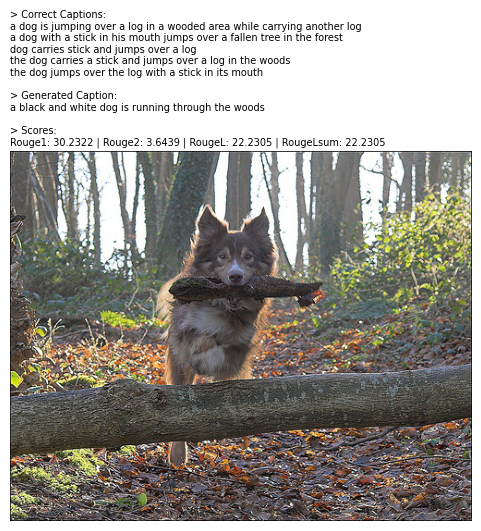



Image 14 --> 382151094_c7376cf22b


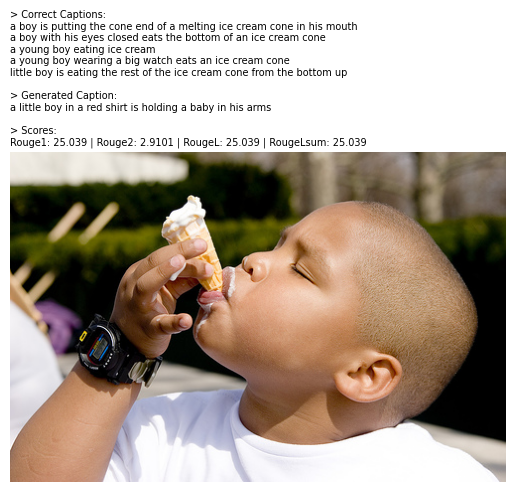



Image 224 --> 445655284_c29e6d7323


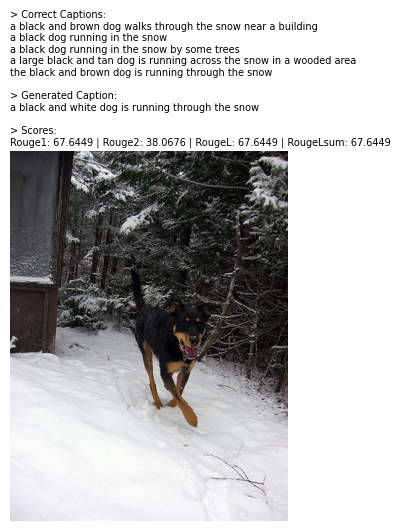



Image 343 --> 480200554_6155e9dfeb


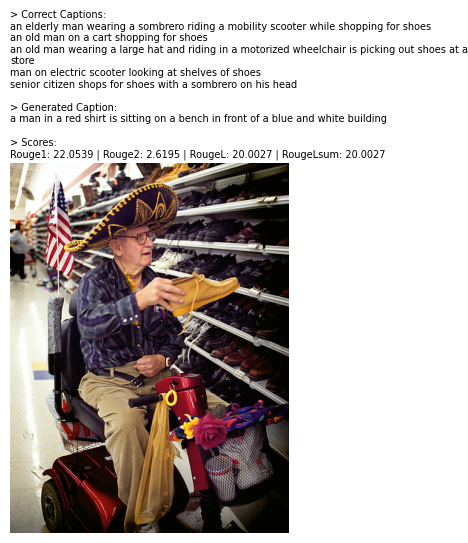



Image 346 --> 481054596_cad8c02103


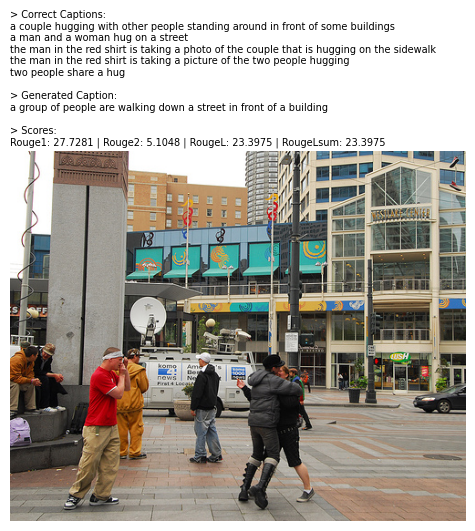



Image 547 --> 527968666_1fcddf81ab


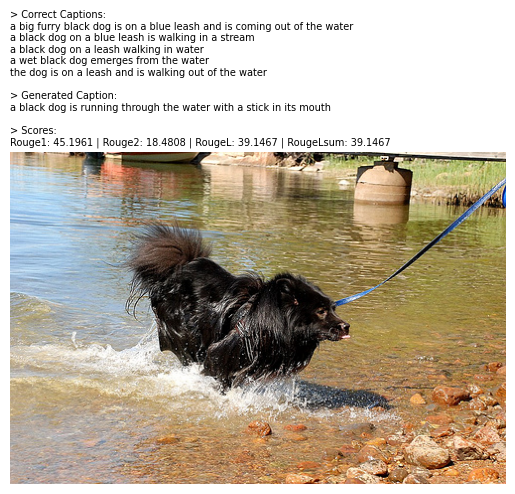



Image 615 --> 541046380_513e295384


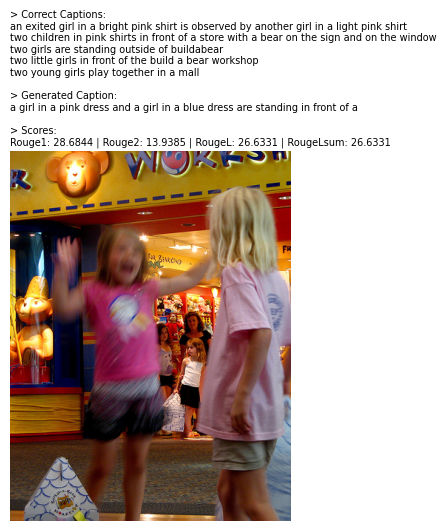



Image 692 --> 597543181_6a85ef4c17


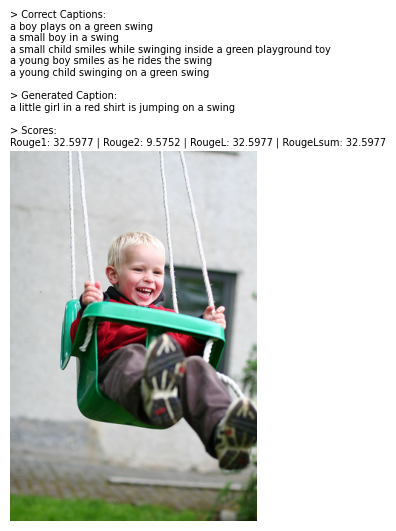



Image 843 --> 801607443_f15956d1ce


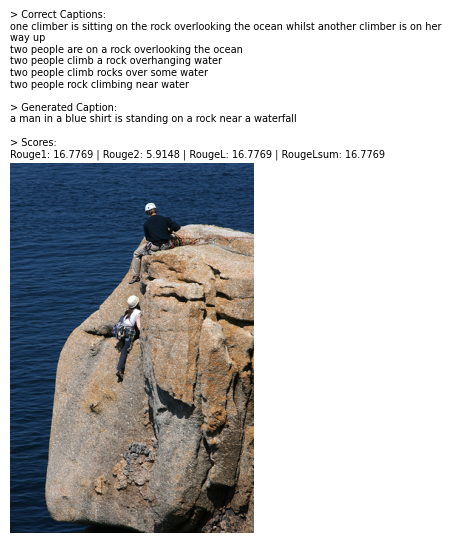



Image 918 --> 90011335_cfdf9674c2


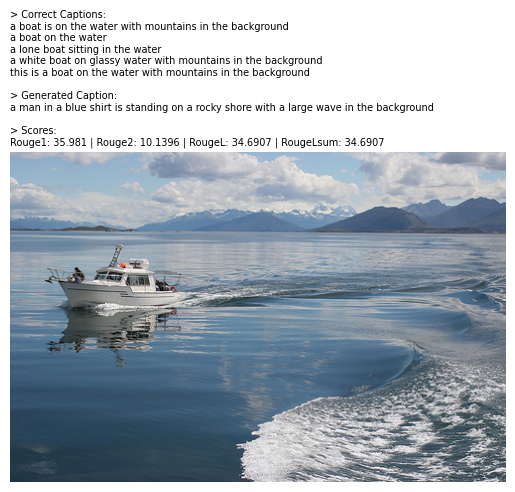



Image 935 --> 937559727_ae2613cee5


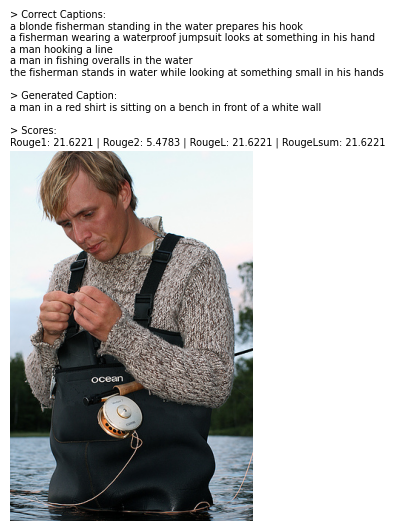

In [ ]:
import cv2
import matplotlib.pyplot as plt
import evaluate
import os

# Function to display images and their captions
def image_display(filepath, correct_caps, gen_caption, scores, font_size, dpi, save_img):
    img_color = cv2.imread(filepath, 1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))

    correct_caps_string = f"> Correct Captions:\n{correct_caps}"
    generated_caption_string = f"> Generated Caption:\n{gen_caption[0]['generated_text']}"
    scores_string = f"> Scores:\nRouge1: {scores['rouge1']} | Rouge2: {scores['rouge2']} | RougeL: {scores['rougeL']} | RougeLsum: {scores['rougeLsum']}"

    title_string = f"{correct_caps_string}\n\n{generated_caption_string}\n\n{scores_string}"
    plt.title(title_string, fontsize=font_size, wrap=True, loc='left')

    if save_img:
        plt.savefig(f"{os.path.splitext(os.path.basename(filepath))[0]}_generation", bbox_inches='tight', dpi=dpi)
    plt.show()

# Function to compute ROUGE scores
def get_scores(correct_caps, gen_caption):
    metric = evaluate.load("rouge")
    correct_caps_list = correct_caps.split("\n")
    rouge_scores = [metric.compute(predictions=[gen_caption], references=[correct_cap]) for correct_cap in correct_caps_list]

    sum_rouge1, sum_rouge2, sum_rougeL, sum_rougeLsum = 0.0, 0.0, 0.0, 0.0

    for score in rouge_scores:
        sum_rouge1 += score['rouge1']
        sum_rouge2 += score['rouge2']
        sum_rougeL += score['rougeL']
        sum_rougeLsum += score['rougeLsum']

    avg_rouge_score = {
        'rouge1': sum_rouge1 / len(rouge_scores),
        'rouge2': sum_rouge2 / len(rouge_scores),
        'rougeL': sum_rougeL / len(rouge_scores),
        'rougeLsum': sum_rougeLsum / len(rouge_scores)
    }

    avg_rouge_score = {k: round(v * 100, 4) for k, v in avg_rouge_score.items()}
    return avg_rouge_score

# Function to generate captions for an image and display them along with their ROUGE scores
def get_caption_for_image(filepath, correct_caps, font_size, dpi=300, save_img=False):
    gen_caption = image_captioner(filepath)
    rouge_scores = get_scores(correct_caps, gen_caption[0]['generated_text'])
    image_display(filepath, correct_caps, gen_caption, rouge_scores, font_size, dpi, save_img)

# Generate captions for a few example images and display the results
examples = [0, 14, 224, 343, 346, 547, 615, 692, 843, 918, 935]
for i in examples:
    instance = grouped_test_ds.__getitem__(i)
    image_path = instance['image']
    caption = instance['caption']
    print(f"\n\nImage {i} --> {os.path.splitext(os.path.basename(image_path))[0]}")
    get_caption_for_image(image_path, caption, font_size=7, dpi=500, save_img=True)